In [2]:
import pandas as pd
import numpy as np
import plotly as plt
import json
import geopandas as gpd
import plotly.graph_objs as go
import pylab as pyl
import matplotlib.pyplot as mpl
import os

In [3]:
def normalize(num, mn, mx):
    val = num - mn
    val = val / (mx - mn)
    return val

In [4]:
MVC_raw = pd.read_csv('../data/NYC_Motor_Vehicle_Collisions.csv',
                         usecols = ['DATE', 'TIME', 'ZIP CODE', 'LATITUDE', 'LONGITUDE'])
MVC_raw.columns = ['date', 'time', 'zip', 'lat', 'long']
MVC = MVC_raw.iloc[1:229419]
MVC = MVC.dropna()
MVC = MVC.astype({'zip': 'int32'})

MVC_by_zip = {}
for mvc in MVC.iterrows():
    if mvc[1][2] in MVC_by_zip.keys():
        MVC_by_zip[mvc[1][2]] = MVC_by_zip[mvc[1][2]] + 1 
    else:
        MVC_by_zip[mvc[1][2]] = 1

C:\Users\caleb\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
accidents = pd.DataFrame.from_dict(MVC_by_zip, orient = 'index')
accidents.columns = ['accidents']
accidents['code'] = accidents.index
accidents.index = list(range(0, len(accidents)))

In [24]:
accidents.to_csv('outpuaccidents_by_zipcode.csv', index = False)

In [6]:
streets_raw = pd.read_csv('../data/NYC_Streets.csv',
                         usecols = ['ST_LABEL', 'POST_TYPE', 'L_ZIP', 'R_ZIP', 'SHAPE_Leng'])
streets_raw.columns = ['zip1', 'zip2', 'name', 'type', 'length']
streets = streets_raw.dropna()
streets = streets.drop(streets[streets.type == 'RTE'].index)
streets = streets.astype({'zip1': 'int32', 'zip2': 'int32'})

street_length_by_zip = dict.fromkeys(MVC_by_zip.keys())
street_length_by_zip = {val:0 for val in street_length_by_zip}
for street in streets.iterrows():
    if street[1][0] in street_length_by_zip.keys() and street[1][1] in street_length_by_zip:
        if street[1][0] == street[1][1]:
            street_length_by_zip[street[1][0]] = street_length_by_zip[street[1][0]] + street[1][4]
        else:
            street_length_by_zip[street[1][0]] = street_length_by_zip[street[1][0]] + street[1][4]/2
            street_length_by_zip[street[1][1]] = street_length_by_zip[street[1][1]] + street[1][4]/2

In [7]:
zips_to_del = list()
for zip_code in street_length_by_zip.keys():
    if street_length_by_zip[zip_code] == 0:
        zips_to_del.append(zip_code)
        
for zip_code in zips_to_del:
    del street_length_by_zip[zip_code]

In [8]:
street_lengths = pd.DataFrame.from_dict(street_length_by_zip, orient = 'index')
street_lengths.columns = ['street_length']
street_lengths['code'] = street_lengths.index
street_lengths.index = list(range(0, len(street_lengths)))

street_length_by_zip = dict.fromkeys(MVC_by_zip.keys())
street_length_by_zip = {val:0 for val in street_length_by_zip}
for street in streets.iterrows():
    if street[1][0] in street_length_by_zip.keys() and street[1][1] in street_length_by_zip:
        if street[1][0] == street[1][1]:
            street_length_by_zip[street[1][0]] = street_length_by_zip[street[1][0]] + street[1][4]
        else:
            street_length_by_zip[street[1][0]] = street_length_by_zip[street[1][0]] + street[1][4]/2
            street_length_by_zip[street[1][1]] = street_length_by_zip[street[1][1]] + street[1][4]/2

In [9]:
zips_to_del = list()
for zip_code in street_length_by_zip.keys():
    if street_length_by_zip[zip_code] == 0:
        zips_to_del.append(zip_code)
        
for zip_code in zips_to_del:
    del street_length_by_zip[zip_code]

In [10]:
street_lengths = pd.DataFrame.from_dict(street_length_by_zip, orient = 'index')
street_lengths.columns = ['street_length']
street_lengths['code'] = street_lengths.index
street_lengths.index = list(range(0, len(street_lengths)))
zip_codes_raw = gpd.read_file('../data/NYC_Zip_Polygons.geojson')
zip_codes = zip_codes_raw.drop(['OBJECTID', '@id', 'PO_NAME', 'STATE', 'borough', 'ST_FIPS', 'CTY_FIPS', 'BLDGpostalCode', 'Shape_Leng'], axis=1)
zip_codes.columns = ['code', 'area', 'geometry']
zip_codes = zip_codes.astype({'code': 'int32'})
zip_codes = zip_codes.drop(zip_codes[zip_codes.area < 500000].index)
zip_codes = zip_codes.drop('area', axis = 1)

In [19]:
map_data = pd.merge(zip_codes, accidents, left_on = 'code', right_on = 'code')
map_data = pd.merge(map_data, street_lengths, left_on = 'code', right_on = 'code')
map_data['street_length'] = map_data['street_length'] / 5280.0
map_data['accident_score'] = map_data.accidents / map_data.street_length
max_score = map_data['accident_score'].max()
min_score = map_data['accident_score'].min()
mean_score = map_data['accident_score'].mean()
map_data['accident_score'] = map_data['accident_score'].apply(lambda x: (normalize(x, min_score, max_score)))
map_geo_data = gpd.GeoDataFrame(map_data, geometry = 'geometry')

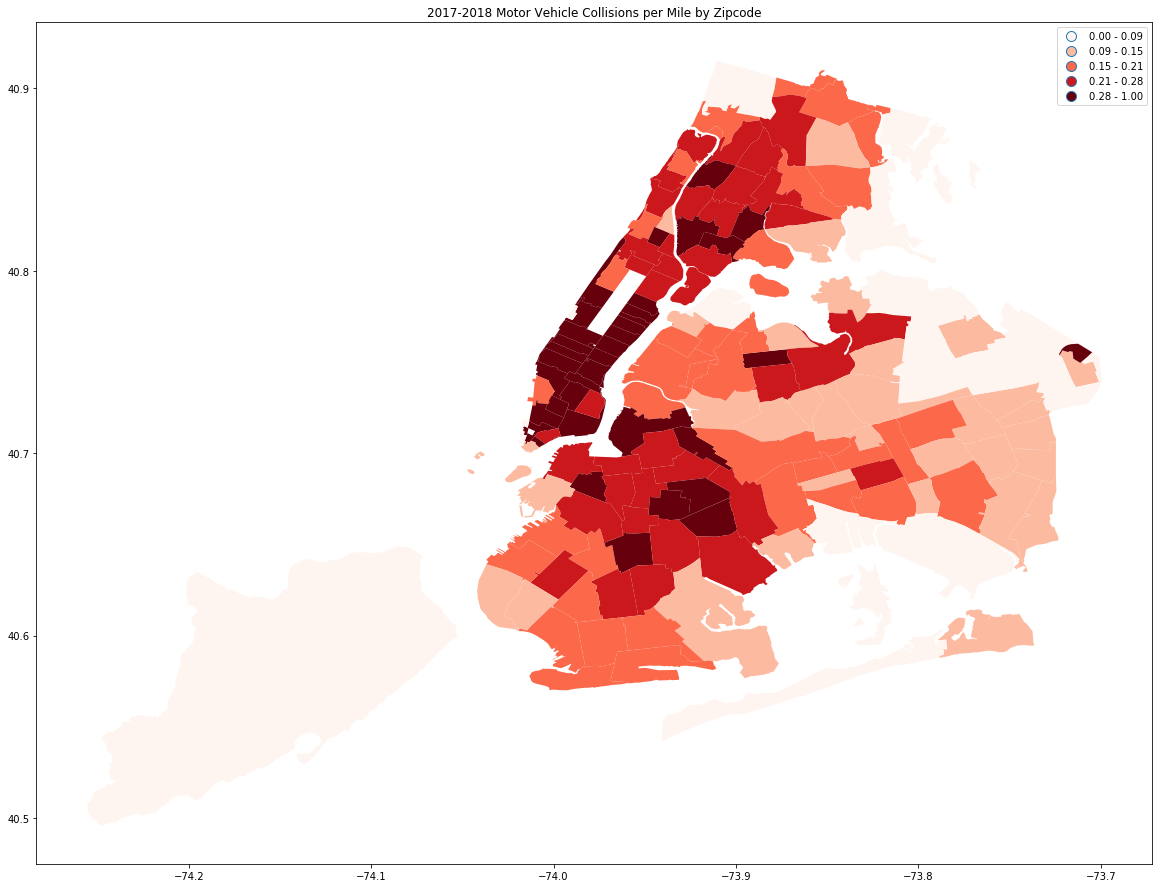

C:\Users\caleb\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning:

Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.



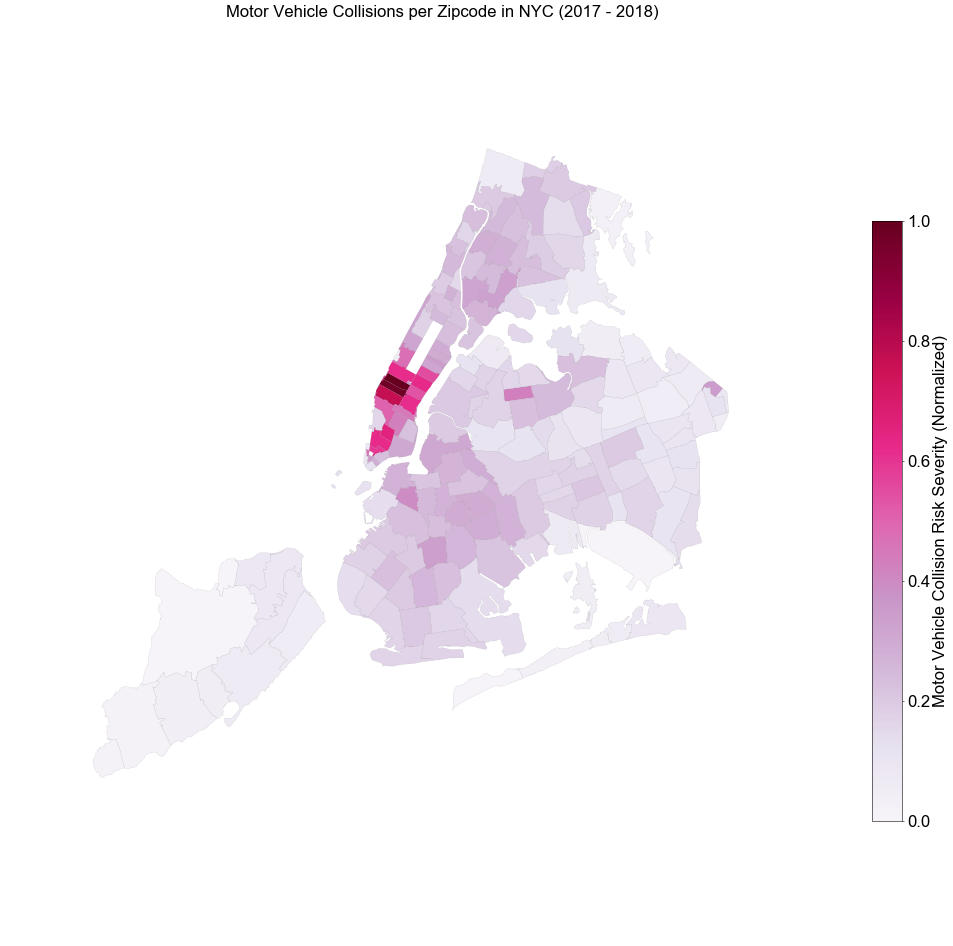

In [20]:
mpl.rcParams['figure.figsize'] = [20, 20]
map_geo_data.plot(column = 'accident_score', cmap = 'Reds', scheme = 'quantiles', legend = True)
mpl.title('2017-2018 Motor Vehicle Collisions per Mile by Zipcode')
mpl.savefig('../output/NYC_MVC_Chloropleth_Map_v1.png')
mpl.show()

chloro_df = map_data

pyl.figure(figsize = (20, 20), dpi = 50)
map_axis = pyl.axes([0.0, 0.0, 0.8, 0.9])
cb_axis = pyl.axes([0.83, 0.1, 0.03, 0.6])
c_map = pyl.cm.PuRd
pyl.axes(map_axis)
pyl.axis([-74.3, -73.6, 40.4, 41.0])
pyl.gca().set_axis_off()

for entry in chloro_df.iterrows():
    polygon_data = list(zip(*entry[1][1].exterior.coords.xy))
    zip_code = entry[1][0]
    accident_score = entry[1][4]
    color = c_map(accident_score)
    patch = pyl.Polygon(polygon_data, 
                    facecolor = color, 
                    edgecolor = (.3, .3, .3, 1), 
                    linewidth = .1)
    pyl.gca().add_patch(patch)

pyl.title('Motor Vehicle Collisions per Zipcode in NYC (2017 - 2018)')
max_accidents = chloro_df.accident_score.max()
cb = pyl.mpl.colorbar.ColorbarBase(cb_axis, cmap=c_map, norm = pyl.mpl.colors.Normalize(vmin=0, vmax = max_accidents))
cb.set_label('Motor Vehicle Collision Risk Severity (Normalized)')
for obj in pyl.gcf().findobj(pyl.matplotlib.text.Text):
    obj.set_fontname('Arial')
    obj.set_fontsize(24)
pyl.savefig('../output/NYC_MVC_Chloropleth_Map_v2.png')

In [ ]:
try: 
    os.remove('../output/geo.geojson')
except OSError:
    pass

geojson_color = map_geo_data
geojson_color.to_file('../output/geo.goejson', driver = 'GeoJSON')